In [1]:
# Helper packages
library(tidyverse)
library(visdat) # for additional visualizations
# Feature engineering packages
library(caret) # for various ML tasks
library(recipes) # for feature engineering tasks

library(rsample)

Warning message:
"package 'tidyverse' was built under R version 4.0.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

Warning message:
"package 'tibble' was built under R version 4.0.3"
Warning message:
"package 'readr' was built under R version 4.0.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'visdat' was built under R version 4.0.3"
Warning message:
"package 'caret' was built under R version 4.0.3"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'recipes' was built under R version 4

In [2]:
ames <- read_csv('data/ames.csv')
set.seed(123)
split <- initial_split(ames, prop = 0.7,
strata = "Sale_Price")
ames_train <- training(split)
ames_test <- testing(split)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_character(),
  Lot_Frontage = col_double(),
  Lot_Area = col_double(),
  Year_Built = col_double(),
  Year_Remod_Add = col_double(),
  Mas_Vnr_Area = col_double(),
  BsmtFin_SF_1 = col_double(),
  BsmtFin_SF_2 = col_double(),
  Bsmt_Unf_SF = col_double(),
  Total_Bsmt_SF = col_double(),
  First_Flr_SF = col_double(),
  Second_Flr_SF = col_double(),
  Low_Qual_Fin_SF = col_double(),
  Gr_Liv_Area = col_double(),
  Bsmt_Full_Bath = col_double(),
  Bsmt_Half_Bath = col_double(),
  Full_Bath = col_double(),
  Half_Bath = col_double(),
  Bedroom_AbvGr = col_double(),
  Kitchen_AbvGr = col_double(),
  TotRms_AbvGrd = col_double()
  # ... with 15 more columns
)
i Use `spec()` for the full column specifications.




In [3]:
# log transformation
ames_recipe <- recipe(Sale_Price ~ ., data = ames_train) %>%
step_log(all_outcomes())

In [4]:
# Take stock of missing values
sum(is.na(AmesHousing::ames_raw))

[1] 13997

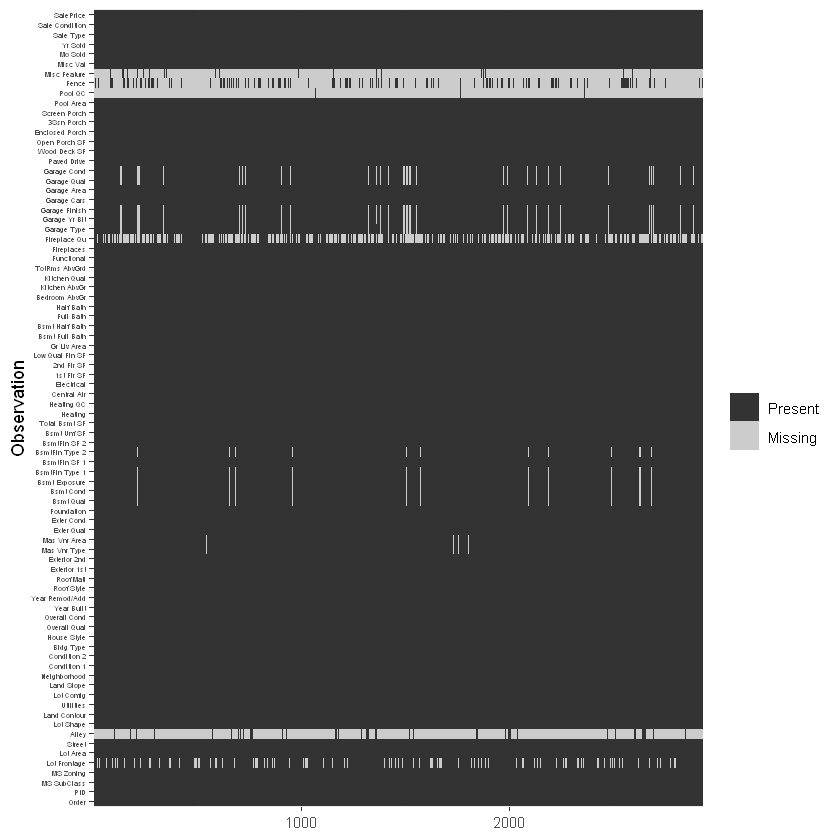

In [5]:
# Visualize missing values

AmesHousing::ames_raw %>%
is.na() %>%
reshape2::melt() %>%
ggplot(aes(Var2, Var1, fill=value)) +
geom_raster() +
coord_flip() +
scale_y_continuous(NULL, expand = c(0, 0)) +
scale_fill_grey(name = "",
labels = c("Present","Missing")) +
xlab("Observation") +
theme(axis.text.y = element_text(size = 4))

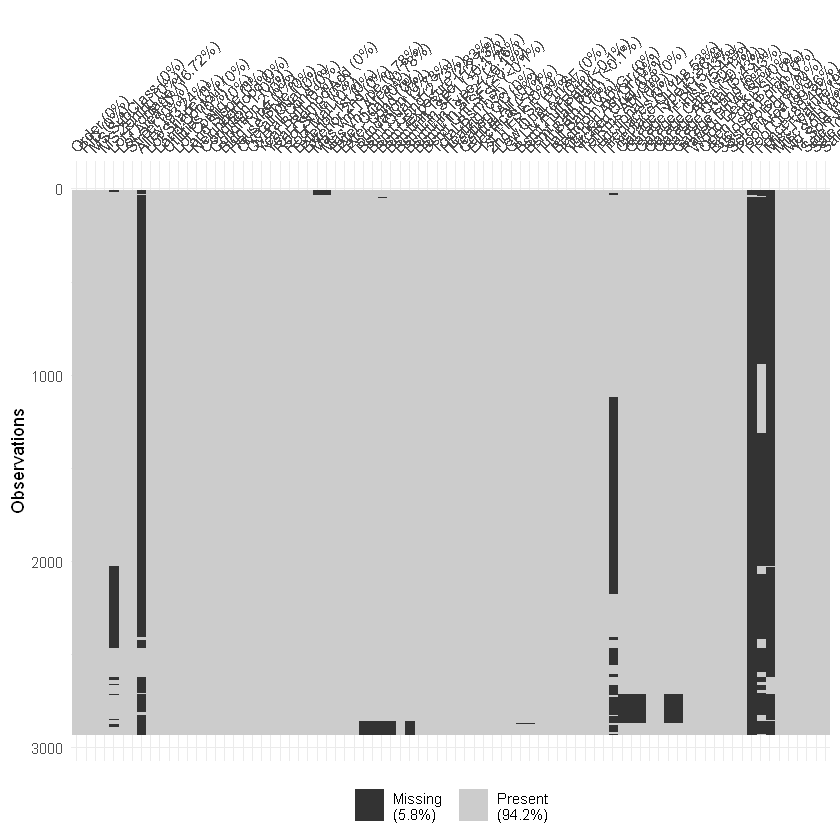

In [6]:
# Check for missing values easily with vis_miss
vis_miss(AmesHousing::ames_raw, cluster = TRUE)

In [7]:
# Median imputation
ames_recipe %>%
    step_medianimpute(Gr_Liv_Area)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
Median Imputation for Gr_Liv_Area

In [8]:
# Knn imputation
ames_recipe %>%
step_knnimpute(all_predictors(), neighbors = 6)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
K-nearest neighbor imputation for all_predictors()

In [9]:
# Bagging imputation
ames_recipe %>%
step_bagimpute(all_predictors())

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
Bagged tree imputation for all_predictors()

In [10]:
# Are there any near-zero variance variables to eliminate? 
# nzv says they are near the threshold

caret::nearZeroVar(ames_train, saveMetrics= TRUE) %>%
rownames_to_column() %>%
filter(nzv)

rowname,freqRatio,percentUnique,zeroVar,nzv
<chr>,<dbl>,<dbl>,<lgl>,<lgl>
Street,292.28571,0.09741841,FALSE,TRUE
Alley,20.52688,0.14612762,FALSE,TRUE
Land_Contour,22.28916,0.19483682,FALSE,TRUE
Utilities,1025.00000,0.14612762,FALSE,TRUE
Land_Slope,22.76744,0.14612762,FALSE,TRUE
Condition_2,203.10000,0.34096444,FALSE,TRUE
Roof_Matl,126.50000,0.24354603,FALSE,TRUE
Bsmt_Cond,19.93478,0.29225524,FALSE,TRUE
BsmtFin_Type_2,21.50617,0.34096444,FALSE,TRUE


In [11]:
# Normalize all numeric columns
recipe(Sale_Price ~ ., data = ames_train) %>%
step_YeoJohnson(all_numeric())
## Data Recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Yeo-Johnson transformation on all_numeric()

In [12]:
# Center and scale all numeric variables
ames_recipe %>%
step_center(all_numeric(), -all_outcomes()) %>%
step_scale(all_numeric(), -all_outcomes())

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
Centering for all_numeric(), -all_outcomes()
Scaling for all_numeric(), -all_outcomes()

In [13]:
count(ames_train, Neighborhood) %>% arrange(n)

Neighborhood,n
<chr>,<int>
Green_Hills,2
Greens,7
Blueste,8
Northpark_Villa,17
Briardale,18
Veenker,20
Bloomington_Heights,21
South_and_West_of_Iowa_State_University,27
Meadow_Village,29


In [14]:
count(ames_train, Screen_Porch) %>% arrange(n)

Screen_Porch,n
<dbl>,<int>
40,1
63,1
80,1
92,1
94,1
99,1
104,1
109,1
110,1


In [16]:
library(Ecdat)

Loading required package: Ecfun


Attaching package: 'Ecfun'


The following object is masked from 'package:base':

    sign



Attaching package: 'Ecdat'


The following object is masked from 'package:datasets':

    Orange




In [21]:
count(Housing, gashw, prefarea)

gashw,prefarea,n
<fct>,<fct>,<int>
no,no,396
no,yes,125
yes,no,22
yes,yes,3


In [25]:
# Lump infrequent categories into 
# an "other" level

# Lump levels for two features
lumping <- recipe(Sale_Price ~ ., data = ames_train) %>%
step_other(Neighborhood, threshold = 0.01,
other = "other") %>%
step_other(Screen_Porch, threshold = 0.1,
other = ">0")

# Apply this blue print --> you will learn about this at
# the end of the chapter
apply_2_training <- prep(lumping, training = ames_train) %>%
bake(ames_train)
# New distribution of Neighborhood
count(apply_2_training, Neighborhood) %>% arrange(n)

Neighborhood,n
<fct>,<int>
Bloomington_Heights,21
South_and_West_of_Iowa_State_University,27
Meadow_Village,29
Clear_Creek,31
Stone_Brook,34
Northridge,48
Timberland,55
Iowa_DOT_and_Rail_Road,62
Crawford,72


In [26]:
# New distribution of Screen_Porch
count(apply_2_training, Screen_Porch) %>% arrange(n)

Screen_Porch,n
<fct>,<int>
>0,174
0,1879


In [27]:
# One-hot encoding
# Lump levels for two features
recipe(Sale_Price ~ ., data = ames_train) %>%
step_dummy(all_nominal(), one_hot = TRUE)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Dummy variables from all_nominal()

In [28]:
# Original categories
count(ames_train, MS_SubClass)

MS_SubClass,n
<chr>,<int>
Duplex_All_Styles_and_Ages,66
One_and_Half_Story_Finished_All_Ages,211
One_and_Half_Story_PUD_All_Ages,1
One_and_Half_Story_Unfinished_All_Ages,11
One_Story_1945_and_Older,91
One_Story_1946_and_Newer_All_Styles,753
One_Story_PUD_1946_and_Newer,145
One_Story_with_Finished_Attic_All_Ages,5
PUD_Multilevel_Split_Level_Foyer,14


In [29]:
recipe(Sale_Price ~ ., data = ames_train) %>%
step_integer(MS_SubClass) %>%
prep(ames_train) %>%
bake(ames_train) %>%
count(MS_SubClass)

MS_SubClass,n
<dbl>,<int>
1,66
2,211
3,1
4,11
5,91
6,753
7,145
8,5
9,14


In [30]:
# Label encoded
recipe(Sale_Price ~ ., data = ames_train) %>%
step_integer(Overall_Qual) %>%
prep(ames_train) %>%
bake(ames_train) %>%
count(Overall_Qual)

Overall_Qual,n
<dbl>,<int>
1,511
2,564
3,170
4,77
5,26
6,439
7,8
8,23
9,231


In [31]:
# PCA and retain 95% of the variance w
# the components

recipe(Sale_Price ~ ., data = ames_train) %>%
step_center(all_numeric()) %>%
step_scale(all_numeric()) %>%
step_pca(all_numeric(), threshold = .95)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Centering for all_numeric()
Scaling for all_numeric()
No PCA components were extracted.

In [ ]:
# left off p 94